In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import tensorflow as tf

In [2]:
lines = [line.rstrip('\n') for line in open('nation_triples.txt')]

In [3]:
fact_list = []
for line in lines:
    fact_list.append([int(x) for x in line.split('\t')])

In [4]:
I = 14
J = 14
K = 56
R = 5
X = np.zeros((K,I,J))

In [5]:
for fact in fact_list:
    k = fact[0]
    i = fact[1]
    j = fact[2]
    X[k,i,j] = 1

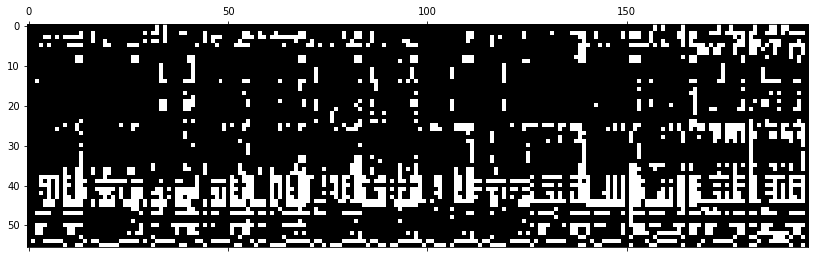

In [6]:
X_Show = X.reshape(K,I*J)
plt.matshow(X_Show, cmap=cm.Greys_r)
plt.show()

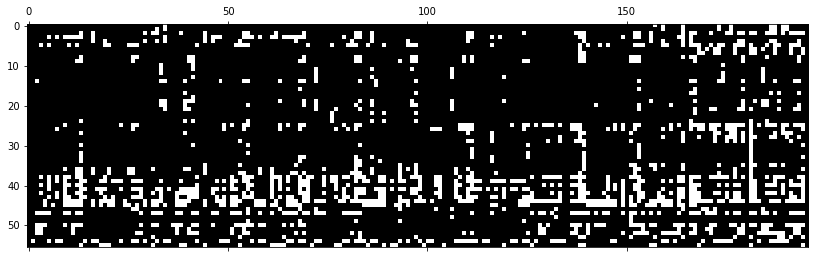

In [7]:
M = np.random.binomial(1,0.8,I*J*K)
M = M.reshape(K,I,J)
X_1 = np.multiply(X,M)
X_Show_M = X_1.reshape(K,I*J)
plt.matshow(X_Show_M, cmap=cm.Greys_r)
plt.show()

In [10]:
X_2 = 1 - X_1

# Gibbs Sampling

In [8]:
def sample_W_H_G(S,W,H,G,a_w,b_w,a_h,b_h,a_g,b_g):
    E_w = np.transpose((S.sum(1)).sum(2))
    E_h = np.transpose((S.sum(1)).sum(1))
    E_g = np.transpose((S.sum(2)).sum(2))
    
    Alfa_w = a_w + E_w
    Beta_w = 1.0/((a_w/b_w)+np.tile(np.sum(np.multiply(H,np.sum(G, axis=0)),axis=0),(I,1)))

    Alfa_h = a_h + E_h
    Beta_h = 1.0/((a_h/b_h)+np.tile(np.sum(np.multiply(W,np.sum(G, axis=0)),axis=0),(J,1)))
                  
    Alfa_g = a_g + E_g
    Beta_g = 1.0/((a_g/b_g)+np.tile(np.sum(np.multiply(W,np.sum(H, axis=0)),axis=0),(K,1)))
    
    Wnew = np.random.gamma(Alfa_w,Beta_w,(I,R))
    Hnew = np.random.gamma(Alfa_h,Beta_h,(J,R))
    Gnew = np.random.gamma(Alfa_g,Beta_g,(K,R))
    
    return Wnew,Hnew,Gnew

In [9]:
def sample_S_masked(X1,X2,W_1,H_1,G_1,W_2,H_2,G_2,M):
    S1 = np.zeros((R,K,I,J))
    S2 = np.zeros((R,K,I,J))
    for i in range(I):
        for j in range(J):
            for k in range(K):
                r_r_1 = X_1[k,i,j]
                r_r_2 = X_2[k,i,j]
                r_n = 1
                w_1 = W_1[i,:]
                h_1 = H_1[j,:]
                g_1 = G_1[k,:]
                w_2 = W_2[i,:]
                h_2 = H_2[j,:]
                g_2 = G_2[k,:]
                p_r_1 = np.multiply(np.multiply(w_1,h_1),g_1)
                p_r_1_mod = p_r_1/(p_r_1.sum())
                p_r_2 = np.multiply(np.multiply(w_2,h_2),g_2)
                p_r_2_mod = p_r_2/(p_r_2.sum())
                if M[k,i,j] == 1:
                    s1 = np.random.multinomial(r_r_1,p_r_1_mod,size=1)
                    s2 = np.random.multinomial(r_r_2,p_r_2_mod,size=1)
                else:
                    p_n = np.concatenate((p_r_1,p_r_2))/(p_r_1.sum()+p_r_2.sum())
                    s = np.random.multinomial(r_n,p_n,size=1)
                    s1 = s[0][0:R]
                    s2 = s[0][R:2*R]
                S1[:,k,i,j] = s1
                S2[:,k,i,j] = s2
    return S1, S2

In [11]:
#Initialize W and H
a_w, b_w = 0.5, 0.1
a_h, b_h = 0.5, 0.1
a_g, b_g = 0.5, 0.1

burn_in_size = 2000
sample_size = 10000
count = 0

S_1_sum = np.zeros((R,K,I,J))
S_1_eval = np.zeros((R,K,I,J))
S_2_sum = np.zeros((R,K,I,J))
S_2_eval = np.zeros((R,K,I,J))

W_1 = np.random.gamma(a_w, a_w/b_w, size=(I,R))
H_1 = np.random.gamma(a_h, a_h/b_h, size=(J,R))
G_1 = np.random.gamma(a_g, a_g/b_g, size=(K,R))

W_2 = np.random.gamma(a_w, a_w/b_w, size=(I,R))
H_2 = np.random.gamma(a_h, a_h/b_h, size=(J,R))
G_2 = np.random.gamma(a_g, a_g/b_g, size=(K,R))

for sample in range(sample_size):
    S_1, S_2 = sample_S_masked(X_1,X_2,W_1,H_1,G_1,W_2,H_2,G_2,M)
    W_1, H_1, G_1 = sample_W_H_G(S_1,W_1,H_1,G_1,a_w,b_w,a_h,b_h,a_g,b_g)
    W_2, H_2, G_2 = sample_W_H_G(S_2,W_2,H_2,G_2,a_w,b_w,a_h,b_h,a_g,b_g)
    if count >= burn_in_size:
        S_1_sum = S_1_sum + S_1
        S_2_sum = S_2_sum + S_2
        S_1_eval = S_1_sum/(count-burn_in_size+1)
        S_2_eval = S_2_sum/(count-burn_in_size+1)
    count = count + 1
    if count%100 == 0:
        print count

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


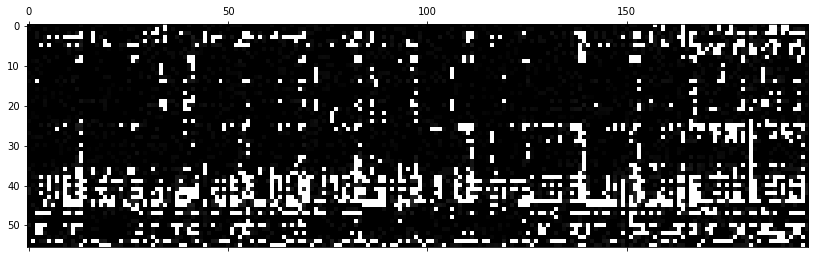

In [12]:
Data_found = np.zeros((K,I,J))

for i in range(I):
    for j in range(J):
        for k in range(K):
            s1 = 0
            s2 = 0
            for r in range(R):
                s1 = s1 + S_1_eval[r,k,i,j]
                s2 = s2 + S_2_eval[r,k,i,j]
                Data_found[k,i,j] = s1/(s1+s2)

Data_show = Data_found.reshape(K,I*J)
plt.matshow(Data_show, interpolation='nearest',vmax=1,vmin=0, cmap=cm.Greys_r)
plt.show()

In [13]:
def precision_recall(X,M,Founded):
    tn = 0
    fn = 0
    tp = 0
    fp = 0
    for k in range(K):
        for i in range(I):
            for j in range(J):
                if M[k,i,j] == 0:
                    if X[k,i,j] == 1:
                        if Founded[k,i,j] == 1:
                            tp = tp + 1
                        else:
                            fn = fn + 1
                    else:
                        if Founded[k,i,j] == 1:
                            fp = fp + 1
                        else:
                            tn = tn + 1
    try:
        precision = (tp*1.0)/(tp+fp)
    except:
        precision = 1
    try:
        recall = (tp*1.0)/(tp+fn)
    except:
        recall = 1
    return precision, recall

In [14]:
def thresh_matrix(D,thresh):
    th_mat = np.zeros((K,I,J))
    for i in range(I):
        for j in range(J):
            for k in range(K):
                if D[k,i,j] > thresh:
                    th_mat[k,i,j] = 1
    return th_mat

In [15]:
prec_list = []
rec_list = []
for thresh in np.linspace(0,1,101):
    founded = thresh_matrix(Data_found,thresh)
    prec, rec = precision_recall(X,M,founded)
    prec_list.append(prec)
    rec_list.append(rec)
    print prec,rec

0.19212040726 1.0
0.19212040726 1.0
0.199172033119 0.997695852535
0.240970654628 0.983870967742
0.327868852459 0.967741935484
0.438073394495 0.880184331797
0.53781512605 0.73732718894
0.643939393939 0.587557603687
0.740585774059 0.407834101382
0.75 0.228110599078
0.855072463768 0.135944700461
0.966666666667 0.0668202764977
1.0 0.0253456221198
1.0 0.0115207373272
1.0 0.00230414746544
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0


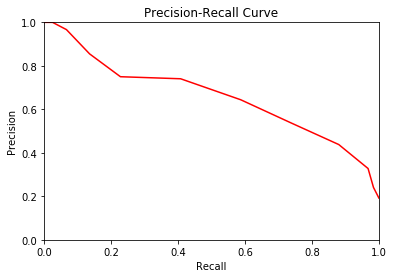

In [21]:
plt.plot(rec_list, prec_list, 'r')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
plt.show()

In [22]:
np.trapz(prec_list[::-1], x=rec_list[::-1])

0.66123581626507888

# EM Algorithm

In [39]:
#EM algorithm
T = 2
MX = np.multiply(M,X_1) + np.multiply(M,X_2)
N = np.ones((K,I,J))
N_til = N - MX
W_1 = np.random.rand(I,R)
H_1 = np.random.rand(J,R)
G_1 = np.random.rand(K,R)
W_2 = np.random.rand(I,R)
H_2 = np.random.rand(J,R)
G_2 = np.random.rand(K,R)
for t in range(T):
    X_1_hat = np.einsum("ir,jr,kr->kij",W_1,H_1,G_1)
    X_2_hat = np.einsum("ir,jr,kr->kij",W_2,H_2,G_2)
    N_til_hat = np.multiply((1-M),X_1_hat) + np.multiply((1-M),X_2_hat)
    Q_1_X = np.divide(np.multiply(M,X_1),X_1_hat)
    Q_2_X = np.divide(np.multiply(M,X_2),X_2_hat)
    Q_1_XHG = np.einsum("ijr,jr->ir",np.einsum("kij,kr->ijr",Q_1_X,G_1),H_1)
    Q_2_XHG = np.einsum("ijr,jr->ir",np.einsum("kij,kr->ijr",Q_2_X,G_2),H_2)
    Q_1_XWG = np.einsum("ijr,ir->jr",np.einsum("kij,kr->ijr",Q_1_X,G_1),W_1)
    Q_2_XWG = np.einsum("ijr,ir->jr",np.einsum("kij,kr->ijr",Q_2_X,G_2),W_2)
    Q_1_XWH = np.einsum("kir,ir->kr",np.einsum("kij,jr->kir",Q_1_X,H_1),W_1)
    Q_2_XWH = np.einsum("kir,ir->kr",np.einsum("kij,jr->kir",Q_2_X,H_2),W_2)
    Q_N = np.divide(np.multiply((1-M),N_til),N_til_hat)
    Q_N = np.nan_to_num(Q_N)
    Q_1_NHG = np.einsum("ijr,jr->ir",np.einsum("kij,kr->ijr",Q_N,G_1),H_1)
    Q_2_NHG = np.einsum("ijr,jr->ir",np.einsum("kij,kr->ijr",Q_N,G_2),H_2)
    Q_1_NWG = np.einsum("ijr,ir->jr",np.einsum("kij,kr->ijr",Q_N,G_1),W_1)
    Q_2_NWG = np.einsum("ijr,ir->jr",np.einsum("kij,kr->ijr",Q_N,G_2),W_2)
    Q_1_NWH = np.einsum("kir,ir->kr",np.einsum("kij,jr->kir",Q_N,H_1),W_1)
    Q_2_NWH = np.einsum("kir,ir->kr",np.einsum("kij,jr->kir",Q_N,H_2),W_2)
    ON = np.ones((K,I,J))
    ON_1_W = np.einsum("ijr,jr->ir",np.einsum("kij,kr->ijr",ON,G_1),H_1)
    ON_2_W = np.einsum("ijr,jr->ir",np.einsum("kij,kr->ijr",ON,G_2),H_2)
    ON_1_H = np.einsum("ijr,ir->jr",np.einsum("kij,kr->ijr",ON,G_1),W_1)
    ON_2_H = np.einsum("ijr,ir->jr",np.einsum("kij,kr->ijr",ON,G_2),W_2)
    ON_1_G = np.einsum("kir,ir->kr",np.einsum("kij,jr->kir",ON,H_1),W_1)
    ON_2_G = np.einsum("kir,ir->kr",np.einsum("kij,jr->kir",ON,H_2),W_2)
    #Update
    W_1 = np.nan_to_num(np.divide(np.multiply(W_1,(Q_1_XHG+Q_1_NHG)),ON_1_W))
    W_2 = np.nan_to_num(np.divide(np.multiply(W_2,(Q_2_XHG+Q_2_NHG)),ON_2_W))
    H_1 = np.nan_to_num(np.divide(np.multiply(H_1,(Q_1_XWG+Q_1_NWG)),ON_1_H))
    H_2 = np.nan_to_num(np.divide(np.multiply(H_2,(Q_2_XWG+Q_2_NWG)),ON_2_H))
    G_1 = np.nan_to_num(np.divide(np.multiply(G_1,(Q_1_XWH+Q_1_NWH)),ON_1_G))
    G_2 = np.nan_to_num(np.divide(np.multiply(G_2,(Q_2_XWH+Q_2_NWH)),ON_2_G))

/Users/semihakbayrak/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide


In [40]:
H_2

array([[ 0.48551863,  0.5242993 ,  0.09399649,  0.42882051,  0.09327663],
       [ 0.55199459,  0.13482111,  0.36981094,  0.43660232,  0.27080398],
       [ 0.45225062,  0.45186037,  0.30215561,  0.40354828,  0.00170504],
       [ 0.15175936,  0.48230329,  0.51598713,  0.36994681,  0.17636188],
       [ 0.30693809,  0.15680681,  0.46512664,  0.31654856,  0.4548615 ],
       [ 0.3935992 ,  0.16210649,  0.50525023,  0.16679724,  0.45402484],
       [ 0.26283556,  0.44723244,  0.66092408,  0.03667528,  0.59551538],
       [ 0.63352346,  0.52979855,  0.05624064,  0.26896666,  0.28824444],
       [ 0.47090554,  0.03577916,  0.5120099 ,  0.19827893,  0.75859892],
       [ 0.0570057 ,  0.18697263,  0.82220763,  0.0415829 ,  0.6533075 ],
       [ 0.15276234,  0.48528373,  0.3229081 ,  0.31171495,  0.47818652],
       [ 0.39190812,  0.31304431,  0.36493811,  0.19842046,  0.46259603],
       [ 0.3947682 ,  0.29303127,  0.14878765,  0.30447161,  0.28858722],
       [ 0.26073171,  0.0178616 ,  0.2

In [41]:
X_1_founded = np.einsum("ir,jr,kr->kij",W_1,H_1,G_1)
X_2_founded = np.einsum("ir,jr,kr->kij",W_2,H_2,G_2)
X_founded = np.divide(X_1_founded,(X_1_founded+X_2_founded))

In [42]:
X_founded

array([[[ 0.67411066,  0.3312358 ,  0.6356152 , ...,  0.70541766,
          0.7308747 ,  0.79651558],
        [ 0.69941953,  0.35491848,  0.5418303 , ...,  0.60718487,
          0.72811101,  0.74266722],
        [ 0.73597524,  0.5143242 ,  0.76381125, ...,  0.80866669,
          0.79286579,  0.85539695],
        ..., 
        [ 0.75470783,  0.49893787,  0.70359091, ...,  0.72450575,
          0.79336918,  0.85359764],
        [ 0.84207032,  0.54951861,  0.67985576, ...,  0.78140785,
          0.87367224,  0.88091443],
        [ 0.8977407 ,  0.62325074,  0.81456451, ...,  0.8534425 ,
          0.90611759,  0.893082  ]],

       [[ 0.63974381,  0.37635353,  0.54489497, ...,  0.59651655,
          0.82807944,  0.83762028],
        [ 0.63059609,  0.34171475,  0.40289046, ...,  0.54400289,
          0.72141753,  0.73955108],
        [ 0.54564052,  0.38583608,  0.51003951, ...,  0.59207659,
          0.76752437,  0.80807814],
        ..., 
        [ 0.71531275,  0.5206896 ,  0.62465696, ...,

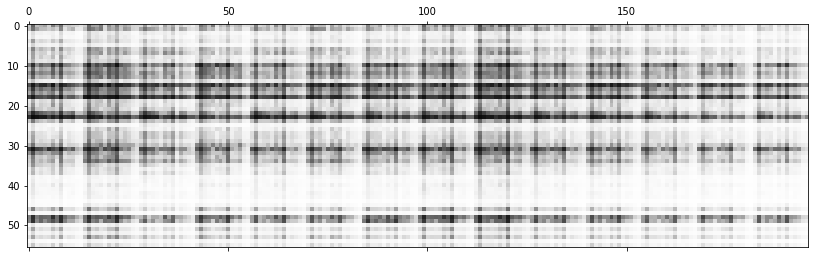

In [43]:
Data_show = X_founded.reshape(K,I*J)
plt.matshow(Data_show, interpolation='nearest',vmax=1,vmin=0, cmap=cm.Greys_r)
plt.show()

In [44]:
prec_list = []
rec_list = []
for thresh in np.linspace(0,1,101):
    founded = thresh_matrix(X_founded,thresh)
    prec, rec = precision_recall(X,M,founded)
    prec_list.append(prec)
    rec_list.append(rec)
    print prec,rec

0.19212040726 1.0
0.19212040726 1.0
0.19212040726 1.0
0.19212040726 1.0
0.19212040726 1.0
0.192205491585 1.0
0.192290651307 1.0
0.192375886525 1.0
0.192632046161 1.0
0.192974655402 1.0
0.193490860455 1.0
0.193663543061 1.0
0.193836534167 1.0
0.194357366771 1.0
0.194793536804 1.0
0.194881005837 1.0
0.195495495495 1.0
0.195760036085 1.0
0.196291270918 1.0
0.196736174071 1.0
0.197093551317 1.0
0.197266514806 0.997695852535
0.197807217908 0.997695852535
0.19826007326 0.997695852535
0.198988970588 0.997695852535
0.199447259327 0.997695852535
0.200277520814 0.997695852535
0.200648748842 0.997695852535
0.201864801865 0.997695852535
0.202336448598 0.997695852535
0.203764705882 0.997695852535
0.204245283019 0.997695852535
0.205225653207 0.995391705069
0.206205250597 0.995391705069
0.207194244604 0.995391705069
0.208192771084 0.995391705069
0.208897485493 0.995391705069
0.209223300971 0.993087557604
0.210243902439 0.993087557604
0.21117099461 0.993087557604
0.211793611794 0.993087557604
0.213366

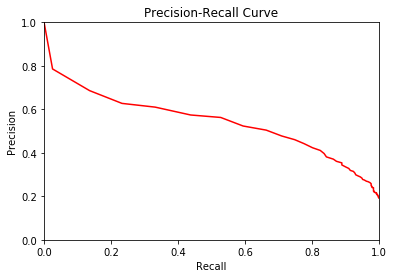

In [45]:
plt.plot(rec_list, prec_list, 'r')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
plt.show()

In [46]:
np.trapz(prec_list[::-1], x=rec_list[::-1])

0.54429275395393095

# Logistic Tensor Factorization

In [85]:
entity1_ind_list = []
entity2_ind_list = []
vals_list = []
for k in range(K):
    entity1_ind = []
    entity2_ind = []
    vals = []
    for i in range(I):
        for j in range(J):
            if M[k,i,j] == 1:
                entity1_ind.append(i)
                entity2_ind.append(j)
                vals.append(X[k,i,j])
    entity1_ind_list.append(entity1_ind)
    entity2_ind_list.append(entity2_ind)
    vals_list.append(vals)

In [86]:
A_mat = tf.Variable(initial_value=tf.truncated_normal([I,R]), name='entities')
R_mat_list = []
res_list = []
res_flatten_list = []
for k in range(K):
    R_mat_list.append(tf.Variable(initial_value=tf.truncated_normal([R,R])))
    res_list.append(tf.sigmoid(tf.matmul(tf.matmul(A_mat,R_mat_list[k]),tf.transpose(A_mat))))
    res_flatten_list.append(tf.reshape(res_list[k],[-1]))

In [87]:
founded_list = []
for k in range(K):
    founded_list.append(tf.gather(res_flatten_list[k],entity1_ind_list[k]*tf.shape(res_list[k])[1]+entity2_ind_list[k]))

In [88]:
op_list = []
base_cost_list = []
for k in range(K):
    op_list.append(tf.add(tf.multiply(tf.log(founded_list[k]),vals_list[k]),tf.multiply(tf.log(tf.subtract(1.0,founded_list[k])),tf.subtract(1.0,vals_list[k]))))
    base_cost_list.append(tf.multiply(-1.0,tf.reduce_sum(op_list[k])))
    
base_cost = tf.reduce_sum(base_cost_list)

In [89]:
# regularization
lda = tf.constant(.001, name='lambda')
norm_sums = tf.add(tf.reduce_sum(tf.abs(A_mat, name='user_abs')),
                   tf.reduce_sum(tf.abs(R_mat_list, name='item_abs')))
regularizer = tf.multiply(norm_sums, lda, 'regularizer')

cost = tf.add(base_cost, regularizer)

In [90]:
# optimizer
lr = tf.constant(.001, name='learning_rate')
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(lr, global_step, 10000, 0.96, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_step = optimizer.minimize(cost, global_step=global_step)

In [91]:
# execute
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for i in xrange(300):
    sess.run(training_step)

In [92]:
rhat = tf.gather(tf.gather(res_list[0], 0), 0)
print str(sess.run(rhat))

2.05802e-05


In [93]:
def founded_tensor():
    th_first = []
    for k in range(K):
        for i in range(I):
            for j in range(J):
                th_first.append(tf.gather(tf.gather(res_list[k], i), j))
    th_second = sess.run(th_first)
    th_second = np.array(th_second)
    th_second = th_second.reshape(K,I,J)
    return th_second

In [94]:
prec_list = []
rec_list = []
Data_found = founded_tensor()
for thresh in np.linspace(0,1,101):
    founded = thresh_matrix(Data_found,thresh)
    prec, rec = precision_recall(X,M,founded)
    prec_list.append(prec)
    rec_list.append(rec)
    print prec,rec

0.19212040726 1.0
0.269620253165 0.981566820276
0.295264623955 0.976958525346
0.315233785822 0.963133640553
0.332792207792 0.944700460829
0.352173913043 0.933179723502
0.36890524379 0.923963133641
0.378248315688 0.905529953917
0.391959798995 0.898617511521
0.405919661734 0.884792626728
0.422048997773 0.873271889401
0.432989690722 0.870967741935
0.446833930705 0.861751152074
0.451294697904 0.84331797235
0.463508322663 0.834101382488
0.467105263158 0.81797235023
0.481582537517 0.8133640553
0.494366197183 0.808755760369
0.504385964912 0.794930875576
0.517450682853 0.785714285714
0.5265625 0.776497695853
0.531847133758 0.769585253456
0.530081300813 0.751152073733
0.537437603993 0.744239631336
0.547619047619 0.741935483871
0.565062388592 0.730414746544
0.576923076923 0.725806451613
0.586142322097 0.721198156682
0.594230769231 0.71198156682
0.6 0.698156682028
0.599198396794 0.688940092166
0.607802874743 0.68202764977
0.613445378151 0.672811059908
0.618025751073 0.663594470046
0.62091503268 0

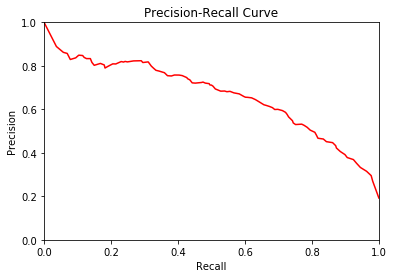

In [95]:
plt.plot(rec_list, prec_list, 'r')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
plt.show()

In [96]:
np.trapz(prec_list[::-1], x=rec_list[::-1])

0.66570394583801173